In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
from netgen.occ import *
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# set up L-shaped domain
outer = MoveTo(-1,-1).Rectangle(2,2).Face()
inner = MoveTo(0,-1).Rectangle(1, 1).Face()
geo = outer-inner
geo.edges.name = "outer"
dom = OCCGeometry(geo, dim=2)

In [3]:
# function to set up system
def sysReset():
    # set up space and mesh
    mesh = Mesh(dom.GenerateMesh(maxh=0.2))
    fes = H1(mesh, order=1, dirichlet="outer", autoupdate=True)

    # functions to process and hold solution
    u, v = fes.TnT()
    gfu = GridFunction(fes, autoupdate=True)

    # define lhs of Poisson problem
    lhs = BilinearForm(fes, symmetric=True)
    lhs += grad(u)*grad(v)*dx
    lhs.Assemble()

    # define rhs of Poisson problem
    if sing:
        ## singularity problem
        r = (x**2+y**2)**(1/2)
        eps = 1e-14
        thetaPre = atan2(y, x)
        theta = IfPos(thetaPre + eps, thetaPre, thetaPre + 2*pi)
        soln = r**(2/3)*sin(theta*2/3)*(1-x**2)*(1-y**2)
        ux = soln.Diff(x)
        uy = soln.Diff(y)
        laplac = ux.Diff(x) + uy.Diff(y)
        f = -laplac
    else:
        ## smooth problem
        f = 2*pi**2*(sin(pi*x)*sin(pi*y))

    rhs = LinearForm(fes)
    rhs += SymbolicLFI(f * v, bonus_intorder=8)
    rhs.Assemble()

    # set up interpolation space for ZZ error
    space_grad = HDiv(mesh, order=1, autoupdate=True)
    recov_grad = GridFunction(space_grad, "recov_grad", autoupdate=True)

    return mesh, fes, gfu, lhs, rhs, u, v, f, space_grad, recov_grad

In [4]:
# function to get true gradient
def getSoln():
    # set up true solution
    if sing:
        #singularity problem
        eps = 1e-14
        thetaPre = atan2(y, x)
        theta = IfPos(thetaPre + eps, thetaPre, thetaPre + 2*pi)
        r = (x**2+y**2)**(1/2)
        soln = r**(2/3)*sin(theta*2/3)*(1-x**2)*(1-y**2)
    else:
        # smooth problem
        soln = sin(pi*x)*sin(pi*y)
    
    return CF((soln.Diff(x), soln.Diff(y)))

In [5]:
# function that marks mesh to be refined using Dörfler marking
def meshRefine(mesh, err):
    # set up sorted error list and total error
    total_err = sqrt(sum(err**2))
    err_id = enumerate(err)
    sort_err = sorted(err_id, key = lambda tup: tup[1], reverse = True)
    
    # mark elements with smallest err not to be refined
    # until marked_err > lambda*total_err
    tol = 0.5
    elements = list(mesh.Elements(VOL))
    marked_err = 0
    
    for entry in sort_err:
        if sqrt(marked_err) > total_err*tol:
            mesh.SetRefinementFlag(elements[entry[0]], False)
        else:
            mesh.SetRefinementFlag(elements[entry[0]], True)
            marked_err += entry[1]**2

    return mesh

In [6]:
# function that calculates Verfürth residual error, taken from 
# https://forum.ngsolve.org/t/residual-type-a-posteriori-error-estimator/2116 and
def ResidErr(gfu, f, mesh):
    # set up
    h = specialcf.mesh_size
    n = specialcf.normal(2)
    
    # calc error
    resT = h*h*(Trace(gfu.Operator("hesse")) + f)**2 * dx
    resE = 1/2*h*( (grad(gfu) - grad(gfu).Other()) * n )**2 * dx(element_vb=BND)
    eta = sqrt(Integrate(resT + resE, mesh, element_wise=True))
    total = sqrt(sum(eta**2))

    # mark for refinement
    mesh = meshRefine(mesh, eta)

    # return usefull quantities
    return eta, total, mesh

In [7]:
# function that calculates ZZ error
def ZZErr(gfu, mesh, recov_grad, space_grad):
    # FEM-grad
    u_grad = grad(gfu)
    # interpolate into H(div)
    recov_grad.Set(u_grad)

    # compute estimator:
    err = (recov_grad-u_grad)**2
    eta = sqrt(Integrate(err, mesh, element_wise=True))
    total = sqrt(sum(eta**2))
    
    # mark for refinement
    mesh = meshRefine(mesh, eta)
    
    # return usefull quantities
    return eta, total, mesh, recov_grad, space_grad

In [8]:
# function to run each FEM iteration
def solveSys(mesh, lhs, rhs, gfu, fes):
    mesh.Refine()
    lhs.Assemble()
    rhs.Assemble()
    gfu.vec.data = lhs.mat.Inverse(fes.FreeDofs()) * rhs.vec

    return mesh, lhs, rhs, gfu, fes

In [9]:
# function to calculate refinement accuracy, can also show where refinement makes mistakes
def show_refine_dif(est_err, true_err, vis_mesh, level, visualise=True):
    # set up sorted error lists and total errors
    est_total_err = sqrt(sum(est_err**2))
    est_err_id = enumerate(est_err)
    est_sort_err = sorted(est_err_id, key = lambda tup: tup[1], reverse=True)

    true_total_err = sqrt(sum(true_err**2))
    true_err_id = enumerate(true_err)
    true_sort_err = sorted(true_err_id, key = lambda tup: tup[1], reverse=True)
    
    # track which elements would be refined in estimated case
    tol = 0.5
    elements = list(vis_mesh.Elements(VOL))
    est_refined = np.zeros(len(elements))
    marked_err = 0

    for entry in est_sort_err:
        if sqrt(marked_err) > est_total_err*tol:
            break
        else:
            est_refined[entry[0]] = -1            
            marked_err += entry[1]**2
            
    # track which elements would be refined in exact case
    true_refined = np.zeros(len(elements))
    marked_err = 0
    for entry in true_sort_err:
        if sqrt(marked_err) > true_total_err*tol:
            break
        else:
            true_refined[entry[0]] = 1
            marked_err += entry[1]**2

    # add vectors to be able to visualise results
    refine_difs = est_refined+true_refined

    # calculate correct rates
    refinement_accuracy = 1-np.count_nonzero(refine_difs)/len(elements)

    # calculate mistake rates
    n_under = np.count_nonzero(refine_difs==1)/len(elements) # elements not refined that should have been
    n_over = np.count_nonzero(refine_difs==-1)/len(elements) # elements refined that should not have been
    
    # visualise
    if visualise:
        vis_space = L2(vis_mesh, order=0)
        vis_grid = GridFunction(vis_space)
        vis_grid.vec.data = true_refined
        Draw(vis_grid)
    print(f"Refinement accuracy at level {level-1}: {refinement_accuracy}")

    return refinement_accuracy, n_under, n_over

In [10]:
# function to run AFEM
def runAFEM(res=True, acc=True):
    # set up problem
    mesh, fes, gfu, lhs, rhs, u, v, f, space_grad, recov_grad = sysReset()
    grad_soln = getSoln()
    
    # set up lists to save data
    tot_est_errs = [] # total estimated error per step
    tot_true_errs = [] # total true error per step
    ref_acc = [] # refinment accuracy of each step
    ref_under = [] # under refinment of each step
    ref_over = [] # over refinment of each step
    ndofs = [] # degrees of freedom of each step
    
    # AFEM loop
    level = 0
    while level < depth: 
        # solve
        mesh, lhs, rhs, gfu, fes = solveSys(mesh, lhs, rhs, gfu, fes)
        if res:
            el_est_err, tot_est_err, mesh = ResidErr(gfu, f, mesh)
        else:
            el_est_err, tot_est_err, mesh, recov_grad, space_grad = ZZErr(gfu, mesh, recov_grad, space_grad)
        level+=1
        
        # work out total true error
        grad_diff = grad_soln - grad(gfu)
        el_true_err = sqrt(Integrate(grad_diff * grad_diff, mesh, element_wise=True))
        tot_true_err = sqrt(sum(el_true_err**2))

        # see mesh differences
        if acc:
            acc, under, over = show_refine_dif(el_est_err, el_true_err, mesh, level, visualise=False)
            ref_acc.append(acc)
            ref_under.append(under)
            ref_over.append(over)
        else:
            print(level)
            
        # save values
        tot_est_errs.append(tot_est_err)
        tot_true_errs.append(tot_true_err)
        ndofs.append(fes.ndof)

    # return values
    return gfu, fes, mesh, tot_est_errs, tot_true_errs, el_est_err, el_true_err, ref_acc, ref_under, ref_over, ndofs

In [11]:
# function to run AFEM without data logging to test speed 
def runAFEM_Speed(tol, res=True):
    # set up problem
    mesh, fes, gfu, lhs, rhs, u, v, f, space_grad, recov_grad = sysReset()
    grad_soln = getSoln()
    
    #start timer
    s = time.process_time_ns()
    
    # AFEM loop
    level = 0
    err = 1e16
    while tol < err: 
        # solve
        mesh, lhs, rhs, gfu, fes = solveSys(mesh, lhs, rhs, gfu, fes)
        if res:
            el_est_err, err, mesh = ResidErr(gfu, f, mesh)
        else:
            el_est_err, err, mehs, recov_grad, space_grad = ZZErr(gfu, mesh, recov_grad, space_grad)
        print(level)
        level+=1

    # end timer
    e = time.process_time_ns()
    dur = e-s

    # get real error
    grad_soln = getSoln()
    grad_diff = grad_soln - grad(gfu)
    true_err = sqrt(Integrate(grad_diff * grad_diff, mesh))

    # return data
    return dur, level+1, true_err, fes.ndof

In [170]:
# function to run AFEM loop without adaptive refinement
def runAFEM_Uniform():
    # first solve using zz and residual
    _, _, _, _, res_errs, _, _, _, _, _, res_dofs = runAFEM(acc=False)

    # get max dofs to set stopping cond for uniform refinement
    max_err = res_errs[-1]

    # run with zz
    mesh, fes, gfu, lhs, rhs, u, v, f, space_grad, recov_grad = sysReset()
    grad_soln = getSoln()

    zz_dofs = []
    zz_errs = []

    level = 0
    err = 1e14
    while err>max_err:
        # solve
        mesh, lhs, rhs, gfu, fes = solveSys(mesh, lhs, rhs, gfu, fes)
        _, _, mesh, recov_grad, space_grad = ZZErr(gfu, mesh, recov_grad, space_grad)
        
        # save data
        ## degrees of freedom
        zz_dofs.append(fes.ndof)
        ## error
        grad_diff = grad_soln - grad(gfu)
        err = sqrt(Integrate(grad_diff * grad_diff, mesh))
        zz_errs.append(err)
        
        level+=1
        print(level)
    
    # run with uniform refinement
    mesh, fes, gfu, lhs, rhs, u, v, f, space_grad, recov_grad = sysReset()
    grad_soln = getSoln()

    dofs = []
    errs = []

    level = 0
    err = 1e14
    while err>max_err:
        # solve
        mesh, lhs, rhs, gfu, fes = solveSys(mesh, lhs, rhs, gfu, fes)

        # save data
        ## degrees of freedom
        dofs.append(fes.ndof)
        ## error
        grad_diff = grad_soln - grad(gfu)
        err = sqrt(Integrate(grad_diff * grad_diff, mesh))
        errs.append(err)
        
        level+=1
        print(level)

    return dofs, errs, res_dofs, res_errs, zz_dofs, zz_errs

In [163]:
# # set up AFEM iteration depth and select problem
# depth = 10
# sing = False

# # do AFEM
# ## Residual
# display(Markdown("### Residual"))
# res_gfu, res_fes, res_mesh, res_tot_est_errs, res_tot_true_errs, \
# res_el_est_err, res_el_true_err, res_ref_acc, res_under, res_over, res_ndofs = runAFEM()
# #Draw(res_gfu)

# ## ZZ
# display(Markdown("### ZZ"))
# zz_gfu, zz_fes, zz_mesh, zz_tot_est_errs, zz_tot_true_errs, \
# zz_el_est_err, zz_el_true_err, zz_ref_acc, zz_under, zz_over, zz_ndofs = runAFEM(res=False)
# Draw(zz_gfu)

In [14]:
# print(f"Residual Refinement Accuracy: {np.mean(res_ref_acc)}\n"+
#       f"ZZ Refinement Accuracy:       {np.mean(zz_ref_acc)}")
# print(f"Residual Under: {np.mean(res_under)}\n"+
#       f"ZZ Under:       {np.mean(zz_under)}")
# print(f"Residual Over: {np.mean(res_over)}\n"+
#       f"ZZ Over:       {np.mean(zz_over)}")

In [91]:
# # time AFEM runs
# sing = False
# res_dur, res_lvl, res_true, res_ndof = runAFEM_Speed(0.5e-1)
# print(f"Residual time: {res_dur*1e-9:.4f}s\n"+
#       f"Residual iterations: {res_lvl-1}\n"+
#       f"Residual True error: {res_true:.4f}\n"+
#       f"Residual NDOF: {res_ndof}")
# zz_dur, zz_lvl, zz_true, zz_ndof = runAFEM_Speed(0.5e-1, res=False)
# print(f"ZZ time: {zz_dur*1e-9:.4f}s\n"+
#       f"ZZ level: {zz_lvl-1}\n"+
#       f"ZZ True error: {zz_true:.4f}\n"+
#       f"ZZ NDOF: {zz_ndof}\n")

# print(f"ZZ-Res Time = {(res_dur - zz_dur)*1e-9:.4f}s\n"+
#      f"ZZ-Res Iterations = {res_lvl - zz_lvl}"+
#      f"ZZ-Res NDOF = {res_ndof - zz_ndof}")

In [195]:
# # Do uniform runs
# sing = True
# depth = 20
# unif_dofs, unif_errs, res_dofs, res_errs, zz_dofs, zz_errs = runAFEM_Uniform()

In [192]:
# set up plot names
if sing:
    case = "Sing"
else:
    case = "Smooth"

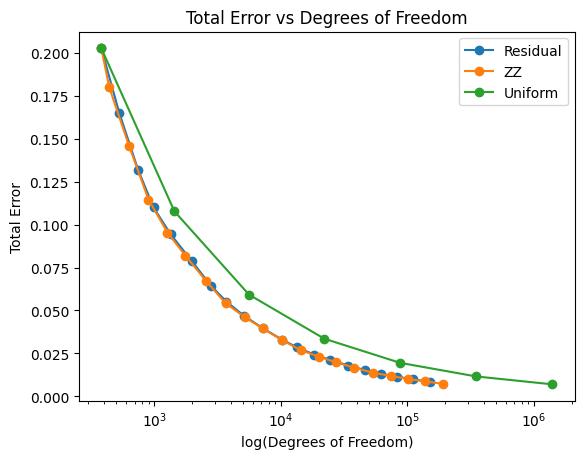

Res total dofs = 578067
ZZ total dofs = 692203
Uniform total dofs = 1861827
192481


In [179]:
# plot results
plt.plot(res_dofs, res_errs, "-o", label = "Residual")
plt.plot(zz_dofs, zz_errs, "-o", label = "ZZ")
plt.plot(unif_dofs, unif_errs, "-o", label = "Uniform")
plt.xscale("log")
plt.xlabel("log(Degrees of Freedom)")
plt.ylabel("Total Error")
plt.title("Total Error vs Degrees of Freedom")
plt.legend()
plt.savefig(f"../Plots/{case}-UniformDof.pdf")
plt.show()

print(f"Res total dofs = {sum(np.array(res_dofs))}")
print(f"ZZ total dofs = {sum(np.array(zz_dofs))}")
print(f"Uniform total dofs = {sum(np.array(unif_dofs))}")

print(zz_dofs[-1])

In [128]:
# # plot errors
# plt.plot(res_tot_true_errs, "-o", label="True Error")
# plt.plot(res_tot_est_errs, "-o", label="Residual Error")
# plt.xticks(np.arange(0, len(res_tot_est_errs), 1.0))
# plt.ylabel("Energy Error")
# plt.xlabel("AFEM Iteration")
# plt.title("Residual Total Error Estimate Performance")
# plt.legend()
# plt.savefig(f"../Plots/{case}-Res.pdf")
# plt.show()

# plt.plot(zz_tot_true_errs, "-o", label="True Error")
# plt.plot(zz_tot_est_errs, "-o", label="ZZ Error")
# plt.xticks(np.arange(0, len(zz_tot_est_errs), 1.0))
# plt.ylabel("Energy Error")
# plt.xlabel("AFEM Iteration")
# plt.title("ZZ Total Error Estimate Performance")
# plt.legend()
# plt.savefig(f"../Plots/{case}-ZZ.pdf")
# plt.show()

# # plot error quot
# plt.plot(np.array(res_tot_est_errs)/np.array(res_tot_true_errs), "-o", label="Residual")
# plt.plot(np.array(zz_tot_est_errs)/np.array(zz_tot_true_errs), "-o", label="ZZ")
# #plt.axhline(y=0, color="r")
# plt.xticks(np.arange(0, len(zz_tot_true_errs), 1.0))
# plt.ylabel("Quotient")
# plt.xlabel("AFEM Iteration")
# plt.title("Estimated Error/True Error")
# plt.legend()
# plt.savefig(f"../Plots/{case}-Quot.pdf")
# plt.show()